# **Tweets classified as agressive or not**

Author: Ezhova Darya (@ezhdi slack)

Dataset https://www.kaggle.com/dataturks/dataset-for-detection-of-cybertrolls

The dataset has 20001 items of which 20001 items have been manually labeled.

The labels are divided into following 2 categories:

1 - Cyber-Aggressive
0 - Non Cyber-Aggressive

In [180]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
import json
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.model_selection import StratifiedKFold

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
PATH_TO_DATA = '/content/gdrive/My Drive/Data/'

**Read the data and have a look at it**

In [184]:
df = pd.read_json(PATH_TO_DATA + '/Dataset for Detection of Cyber-Trolls.json', lines= True)
df.head()

,annotation,content,extras
0,"{'notes': '', 'label': ['1']}",Get fucking real dude.,NaN
1,"{'notes': '', 'label': ['1']}",She is as dirty as they come and that crook ...,NaN
2,"{'notes': '', 'label': ['1']}",why did you fuck it up. I could do it all day...,NaN
3,"{'notes': '', 'label': ['1']}",Dude they dont finish enclosing the fucking s...,NaN
4,"{'notes': '', 'label': ['1']}",WTF are you talking about Men? No men thats n...,NaN


In [185]:
df.shape

(20001, 3)

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20001 entries, 0 to 20000
Data columns (total 3 columns):
annotation    20001 non-null object
content       20001 non-null object
extras        0 non-null float64
dtypes: float64(1), object(2)
memory usage: 625.0+ KB


**Delete null column extras, transform target column annotation and make some new features**

In [0]:
df.drop(columns = ['extras'], inplace = True)

In [0]:
df.rename(columns = {'annotation' : 'label'}, inplace = True)

In [0]:
df.label = df.label.apply(lambda x : int(x['label'][0]))

In [190]:
df.head()

,label,content
0,1,Get fucking real dude.
1,1,She is as dirty as they come and that crook ...
2,1,why did you fuck it up. I could do it all day...
3,1,Dude they dont finish enclosing the fucking s...
4,1,WTF are you talking about Men? No men thats n...


In [191]:
df[df['label'] == 0].sample(5).content

19423                       When was your last plane ride?
12423    Checked out the site and subscribed on iTunes....
11529    must do you head in having an application that...
10193    hate to say it but getting very close to releg...
11034    Comics version: http://en.wikipedia.org/wiki/C...
Name: content, dtype: object

In [192]:
df[df['label'] == 1].sample(5).content

3194    Heh  his name's Jeremy (stupid little nerd  bu...
2122                                             fuck off
3700    And I want a mansion in the countryside  a mot...
1616         what the fuck do you have to apologize for??
3327    omg omg omg! finally the shoes r coming out ya...
Name: content, dtype: object

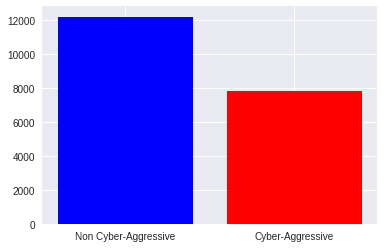

In [193]:
_, ax = plt.subplots()
plt.bar(np.arange(2), df['label'].value_counts(), color = ['blue', 'red'])
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['Non Cyber-Aggressive', 'Cyber-Aggressive']);

In [194]:
df['label'].value_counts()[1] / df.shape[0], df['label'].value_counts()[0] / df.shape[0]

(0.39108044597770114, 0.6089195540222989)

In [0]:
df['len'] = df['content'].apply(lambda x : len(x.strip().split()))

In [0]:
import regex as re 

In [0]:
df['capital'] = df['content'].apply(lambda x : sum(1 for c in x if c.isupper()))

In [0]:
df['punct'] = df['content'].apply(lambda x : len(re.findall("[^\P{P}-]+", x)))
df['punct'] = df['content'].apply(lambda x : len(re.findall("[^\P{P}-]+", x)))

In [0]:
df['content'] = df['content'].apply(lambda x : re.sub("[^\P{P}-]+", "", x))

In [0]:
df['content'] = df['content'].apply(lambda x : str.lower(x))

In [201]:
symbols = {}
for x in [item for sublist in list(map(list, df['content'].tolist())) for item in sublist] :
    if x in symbols :
        symbols[x] += 1
    else :
        symbols[x] = 1
symbols

{' ': 257558,
 '$': 137,
 '+': 131,
 '-': 2121,
 '0': 1019,
 '1': 769,
 '2': 941,
 '3': 1023,
 '4': 400,
 '5': 374,
 '6': 243,
 '7': 232,
 '8': 363,
 '9': 294,
 '<': 203,
 '=': 241,
 '>': 35,
 '^': 50,
 '`': 7,
 'a': 86393,
 'b': 16983,
 'c': 26567,
 'd': 36600,
 'e': 104464,
 'f': 19569,
 'g': 24486,
 'h': 58545,
 'i': 71229,
 'j': 3000,
 'k': 19024,
 'l': 43265,
 'm': 30832,
 'n': 61949,
 'o': 86476,
 'p': 17412,
 'q': 864,
 'r': 46623,
 's': 63639,
 't': 91603,
 'u': 40885,
 'v': 9412,
 'w': 24918,
 'x': 1588,
 'y': 32553,
 'z': 1460,
 '|': 15,
 '~': 67}

In [0]:
digits = '0123456789'
df['num'] = df['content'].apply(lambda x : 1 if len([s for s in x if s in digits]) > 0 else 0)

In [203]:
df.head()

,label,content,len,capital,punct,num
0,1,get fucking real dude,4,1,1,0
1,1,she is as dirty as they come and that crook ...,25,5,3,0
2,1,why did you fuck it up i could do it all day ...,30,3,5,0
3,1,dude they dont finish enclosing the fucking s...,21,4,4,0
4,1,wtf are you talking about men no men thats no...,15,5,3,0


In [0]:
target = df['label'].values

**Split dataset on train and test**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = 0.3, stratify = target, random_state = 31)

In [206]:
y_train.sum() / len(y_train), y_test.sum() / len(y_test)

(0.39107142857142857, 0.39110148308615234)

In [207]:
X_train.shape, X_test.shape

((14000, 6), (6001, 6))

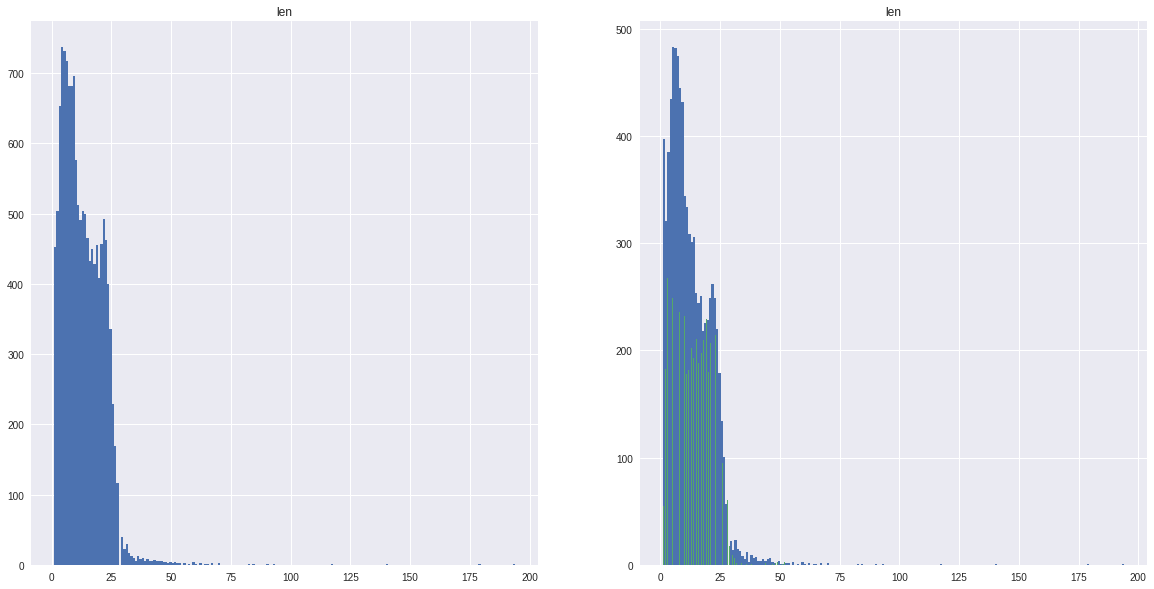

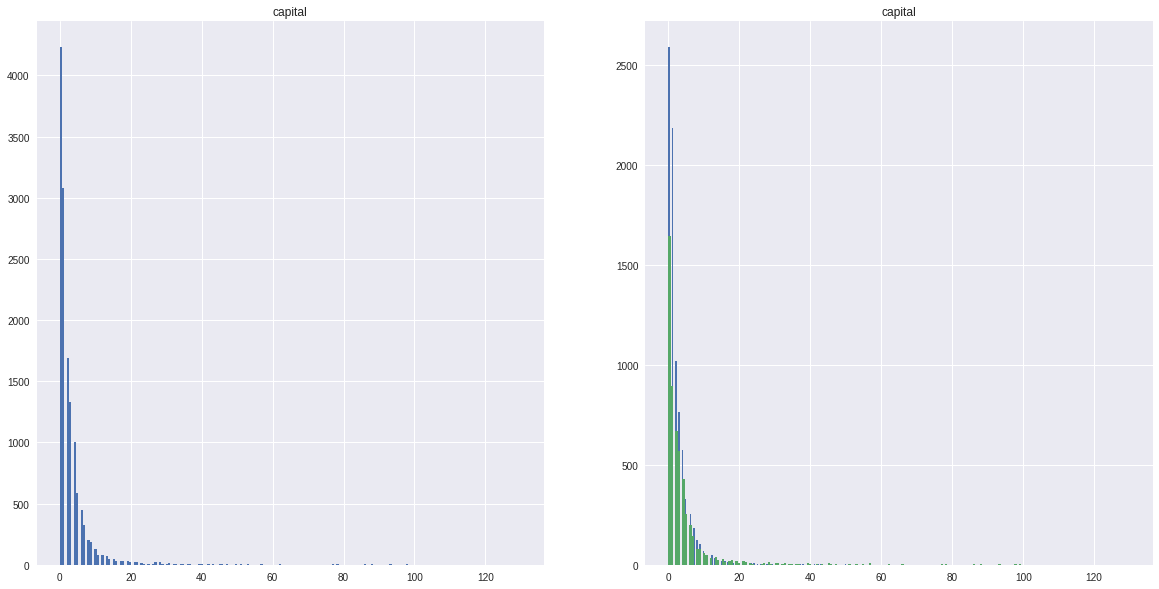

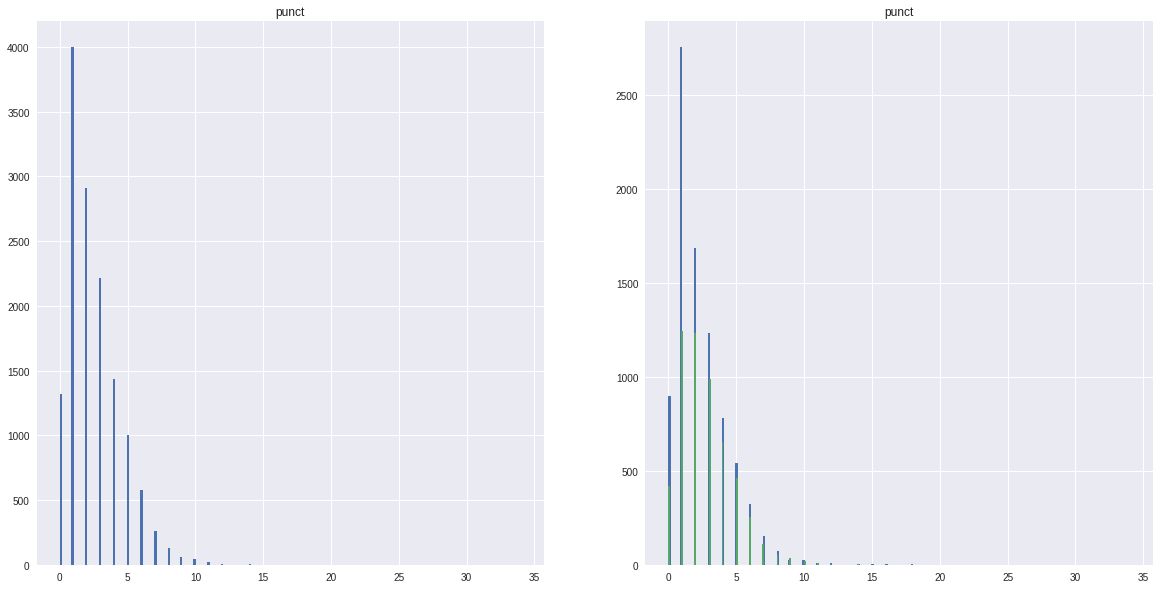

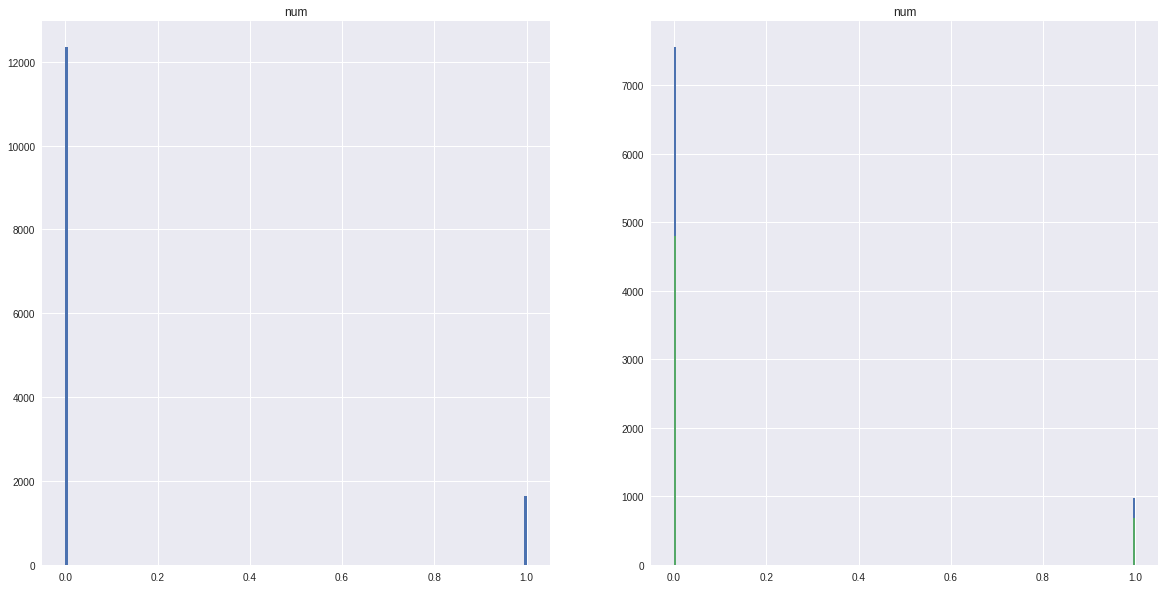

In [208]:
for col in X_train.columns[2 :] :
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
    axes[0].set_title(col)
    axes[0].hist(X_train[col], bins = 200);
    axes[1].set_title(col)
    axes[1].hist(X_train[col][X_train['label'] == 0], bins = 200, label = 'normal')
    axes[1].hist(X_train[col][X_train['label'] == 1], bins = 200, label = 'agressive')
    plt.show()

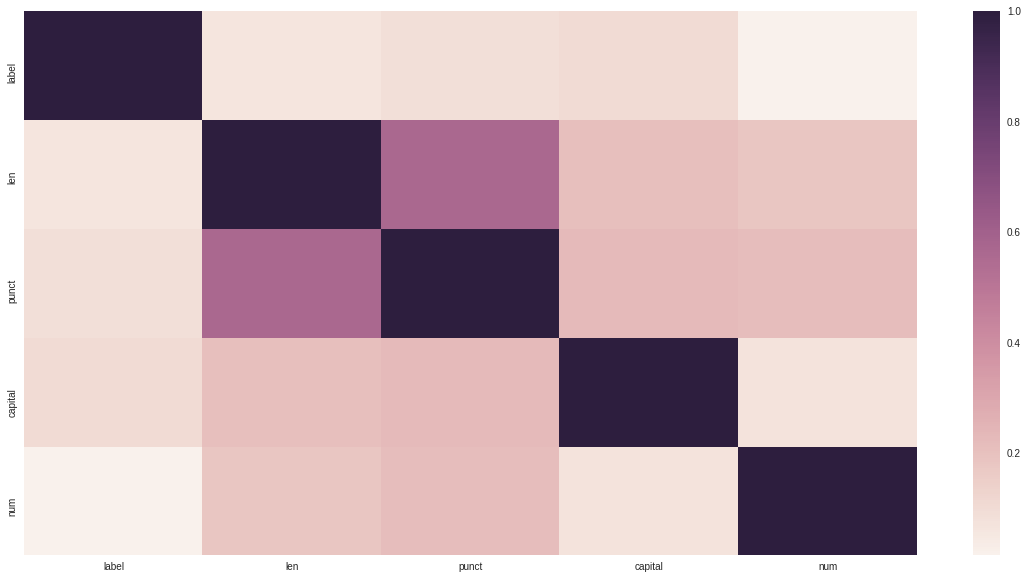

In [209]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(X_train[['label', 'len', 'punct', 'capital','num']].corr())

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [0]:
cols = ['len', 'punct', 'capital', 'num']
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[cols]), columns = cols)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[cols]), columns = cols)

In [0]:
def valid(model, n, bayes = False) :
    skf = StratifiedKFold(n_splits = n, random_state = 31)
    auc_scores = []
    for train_index, valid_index in skf.split(X_train_scaled, y_train):
        X_train_part, X_valid = X_train_scaled.iloc[train_index], X_train_scaled.iloc[valid_index]
        y_train_part, y_valid = y_train[train_index], y_train[valid_index]
        
        X_train_sms, X_valid_sms = X_train.iloc[train_index]['content'], X_train.iloc[valid_index]['content']
        cv = TfidfVectorizer(ngram_range = (1, 3))
        X_train_bow = cv.fit_transform(X_train_sms)
        X_valid_bow = cv.transform(X_valid_sms)     
        if bayes :
            X_train_new = X_train_bow
            X_valid_new = X_valid_bow
        else :
            X_train_new = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_train_bow, X_train_part]))
            X_valid_new = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_valid_bow, X_valid]))
        model.fit(X_train_new, y_train_part)
        model_pred_for_auc = model.predict_proba(X_valid_new)
        auc_scores.append(roc_auc_score(y_valid, model_pred_for_auc[:, 1]))
    return np.mean(auc_scores)

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state = 31)
bayes = MultinomialNB()

In [0]:
from sklearn.metrics import roc_auc_score, precision_score

In [215]:
scores_logit = valid(logit, 10)
print('Logistic regreession - rocauc : {}'.format(scores_logit))

Logistic regreession - rocauc : 0.8568175210273786


In [216]:
scores_bayes = valid(bayes, 10, True)
print('Bayessian classfier - rocauc : {}'.format(scores_bayes))

Bayessian classfier - rocauc : 0.9389266812391538


In [0]:
def valid_for_valid_plots(model, n, bayes = False) :
    skf = StratifiedKFold(n_splits = n, random_state = 17)
    auc_scores_cv = []
    auc_scores_valid = []
    for train_index, valid_index in skf.split(X_train_scaled, y_train):
        X_train_part, X_valid = X_train_scaled.iloc[train_index], X_train_scaled.iloc[valid_index]
        y_train_part, y_valid = y_train[train_index], y_train[valid_index]
        
        X_train_sms, X_valid_sms = X_train.iloc[train_index]['content'], X_train.iloc[valid_index]['content']
        cv = TfidfVectorizer(ngram_range = (1, 3))
        X_train_bow = cv.fit_transform(X_train_sms)
        X_valid_bow = cv.transform(X_valid_sms)     
        if bayes :
            X_train_new = X_train_bow
            X_valid_new = X_valid_bow
        else :
            X_train_new = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_train_bow, X_train_part]))
            X_valid_new = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_valid_bow, X_valid]))
            
        model.fit(X_train_new, y_train_part)
        auc_scores_cv.append(roc_auc_score(y_train_part, model.predict_proba(X_train_new)[:, 1]))
        model_pred_for_auc = model.predict_proba(X_valid_new)
        auc_scores_valid.append(roc_auc_score(y_valid, model_pred_for_auc[:, 1]))
    return 1 - np.mean(auc_scores_valid), 1 - np.mean(auc_scores_cv)

In [0]:
Cs = [0.1 * i for i in range(1, 11)]

In [0]:
scores = []
for c in Cs :
    logit = LogisticRegression(C = c, random_state = 31)
    scores.append(valid_for_valid_plots(logit, 10))

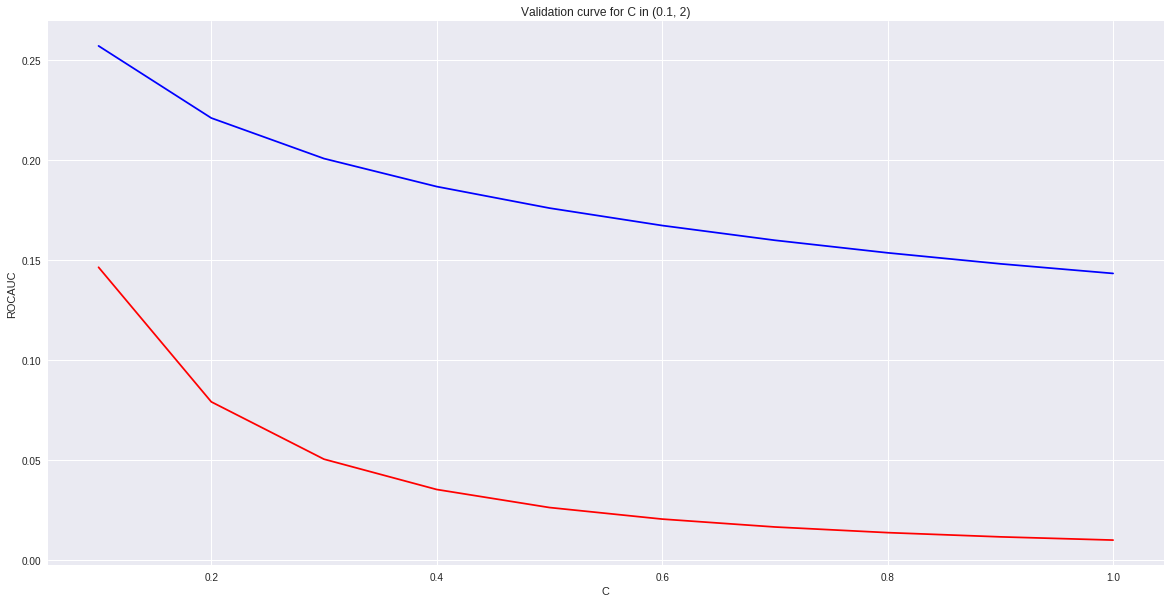

In [220]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
plt.plot(Cs, [i[0] for i in scores], color = 'blue', label='holdout')
plt.plot(Cs, [i[1] for i in scores], color = 'red', label='CV')
plt.ylabel("ROCAUC")
plt.xlabel("C")
plt.title('Validation curve for C in (0.1, 2)');

In [0]:
Cs = np.linspace(0.5, 1.5, 10)

In [222]:
for c in Cs :
    logit = LogisticRegression(C = c, random_state = 31)
    print(c, valid(logit, 10))

0.5 0.8241860844309155
0.6111111111111112 0.8337596053657842
0.7222222222222222 0.8417454791901902
0.8333333333333333 0.8484430574992515
0.9444444444444444 0.8542453325430589
1.0555555555555556 0.8593115989435154
1.1666666666666665 0.8637575109449129
1.2777777777777777 0.8677458297389586
1.3888888888888888 0.8713198493889047
1.5 0.8746141970177508


In [0]:
C_opt = 1.5

In [0]:
cv = TfidfVectorizer(ngram_range = (1, 3))
X_train_content = cv.fit_transform(X_train['content'])
X_test_content = cv.transform(X_test['content'])

In [0]:
train = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_train_content, X_train_scaled]))
test = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_test_content, X_test_scaled]))

In [0]:
logit = LogisticRegression(C = C_opt, random_state = 31)

In [227]:
logit.fit(train, y_train)

LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=31, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [228]:
for x, y in zip(cols, logit.coef_[0][len(cv.get_feature_names()) :]) :
    print(x, y)

len 0.11302153487714969
punct 0.09640665282509607
capital 0.14750706687579546
num -0.015048161446963243


In [0]:
logit_pred = logit.predict_proba(test)

In [230]:
roc_auc_score(y_test, logit_pred[:, 1])

0.8741816347086464